## Chapter 7 - Ensemble Learning and Random Forests

### Boosting

Boosting is an Ensemble method that combines several weak learners to create a strong learner. The general idea is to train predictors sequentially, each trying to correct its predecessor. 

The most popular boosting methods are Adaboost and Gradient Boosting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.datasets import make_moons

One way for a new predictor to correct its predecessor is to pay more attention to the training instances that the predecessor underfitted. This results in predictors focusong more and more of the wrongly classified cases. This is the technique used by Adaboost.

To build an Adaptive Boosting (Adaboost) classifier, a base classifier is trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased. A second classifier is trained using the updated weights and makes predictions on the training set, and so on.

Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, but predictors that have different weights depending on their overall accuracy on the weighted training set.

In [2]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
# Train for Adaboost classifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, 
                            learning_rate=0.5, algorithm='SAMME.R')
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)

A weight is applied to every example in the training data. Initially, they are all equal so $w^{(i)}=\frac 1m$. A first predictor is trained. The errors are calculated using the error rate $r$.

$$r = \frac{\sum_{i=1,\hat{y}^{(i)} \neq {y}^{(i)}}^M w^{(i)}}{\sum_{i=1}^M w^{(i)}}$$
The numerator is sum of weights of all incorrectly classified instances while the denominator is sum of weights of all instances.

The predictor's weight $\alpha$ is computed using $\eta \log \frac{1-r}{r}$ where $\eta$ is the learning rate.

Now, a second predictor is trained on the training set again. But the weights of the training set are adjusted so the examples correctly classified have a smaller weight and those that were wrongly classified have a larger weight. To do so, 

$$w_\text{new} = \begin{cases}\frac{w_\text{old} \exp(\alpha)}{\sum_i w^{(i)}} \text{ if classified correctly or }\hat{y}^{(i)} = {y}^{(i)}\\\frac{w_\text{old} \exp(-\alpha)}{\sum_i w^{(i)}} \text{ if classified incorrectly or }\hat{y}^{(i)} \neq {y}^{(i)}\end{cases}$$


With multiple predictors and weights, the predicted class is the one that receives the maximum score of the weighted votes. 

For gradient boosted trees, it also addes predictors sequentially to the ensemble. However, instead of tweaking the weights of the instance, the method fits the new predcitor to the residual errors made by the previous predictor.

In [4]:
# Train for Adaboost classifier
gbt_clf = GradientBoostingClassifier(max_depth=2, n_estimators=3, learning_rate=1.0)
gbt_clf.fit(X_train, y_train)
y_pred = gbt_clf.predict(X_test)

To find the optimal number of trees, you can use early stopping. A simple way to see this is to use `staged_predict()`. It returns an iterator over the predictions made by the ensemble at each stage of the training.

In [5]:
gbrt = GradientBoostingClassifier(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=120,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [6]:
# After every tree is built, find the MSE of the predictions of that particular ensemble.
errors = [mean_squared_error(y_test, y_pred_i) for y_pred_i in gbrt.staged_predict(X_test)]
print(errors[:30])

# Of the errors, find the trees that have made the minimum MSE.
best_n_estimators = np.argmin(errors)

# This means that best_n_estimators is 22. The best ensemble contains 22 trees.
print(best_n_estimators)

# Then use this number of trees as the best classifier.
gbrt_best = GradientBoostingClassifier(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(X_train, y_train)

[0.104, 0.112, 0.104, 0.112, 0.104, 0.112, 0.104, 0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.112, 0.088, 0.088, 0.112, 0.112, 0.088, 0.088, 0.088, 0.088]
22


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=22,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [7]:
errors_df = pd.DataFrame({'i' : range(len(errors)), 'e' : errors})

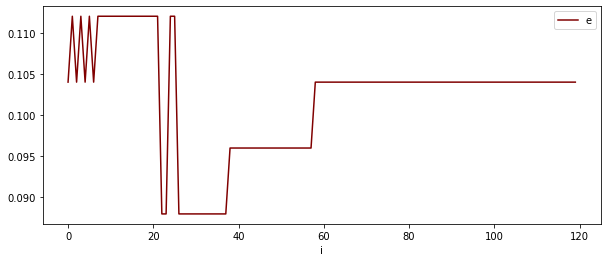

In [8]:
# Plotting for different alpha values
fig, ax = plt.subplots(figsize=(10,4))
errors_df.plot(kind='line', x='i', y='e', ax=ax, color='maroon')
plt.show()

Another way is to actually stop early:

In [9]:
# warm_start=True keeps existing trained trees after fit() is called
# subsample=0.25 means use only 25% of the training instances, sampled randomly
gbrt_growing = GradientBoostingClassifier(max_depth=2, warm_start=True, subsample=0.25) 
min_val_error = float('inf')

error_going_up = 0

for n_estimators in range(1, 120):
    gbrt_growing.n_estimators = n_estimators
    gbrt_growing.fit(X_train, y_train)
    y_pred = gbrt_growing.predict(X_test)
    validation_error = mean_squared_error(y_test, y_pred)
    print(validation_error)
    if validation_error < min_val_error:
        print('if')
        min_val_error = validation_error
        error_going_up = 0
    else:
        print('else')
        error_going_up +=1
        if error_going_up == 5:
            break
            
print(n_estimators)

0.136
if
0.136
else
0.136
else
0.128
if
0.112
if
0.12
else
0.112
else
0.128
else
0.12
else
0.128
else
10
